In [1]:
import os
from datetime import datetime
import collections
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
EPSILON = 0.01

In [11]:
class NooksExperiment:
    
    def _init_graphs(self):
        self.network_graph = nx.Graph()
        self.nooks_graph = nx.Graph()
        
        nft = len(self.member_vectors[0])
        self.graph_colors = []
        
        if nft == 1:
            color = self.member_vectors
        else:
            pca = PCA(n_components=1)
            color = pca.fit_transform(self.member_vectors)
        
        self.graph_colors = color.reshape(-1)
            
        for member in range(self.total_members):
            self.network_graph.add_node(member)
            self.nooks_graph.add_node(member)
        
    def __init__(self, member_vectors, alpha):
        self.total_members = len(member_vectors)
        self.member_vectors = member_vectors
        self.interacted = np.zeros((self.total_members, self.total_members))
        self.all_interactions = np.zeros((self.total_members, self.total_members))
        self.alpha = alpha
        self._init_graphs()
        
        self.network_output_folder = "Images/Network/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
        self.nooks_output_folder = "Images/Nooks/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
        
        os.makedirs(self.network_output_folder)
        os.makedirs(self.nooks_output_folder)
        
        
    def reset(self):
        self.interacted = np.zeros((self.total_members, self.total_members))
    
    def _update_interacted(self, member_allocs, nooks_allocs):
        for member in range(self.total_members):
            if not member in member_allocs:
                continue
            self.interacted[member] += nooks_allocs[member_allocs[member]]
            self.all_interactions[member] += nooks_allocs[member_allocs[member]]
        
    # TODO see if running median is needed; space & time 
    def _create_nook_allocs(self, num_nooks, nook_creators, nook_swipes):
        
        nooks_allocs = np.zeros((num_nooks, self.total_members))
        member_allocs = {}
        nooks_mem_cnt = np.ones((num_nooks))
        nooks_mem_int_cnt = np.zeros((num_nooks, self.total_members))
                            
        
        for nook in range(num_nooks):
            nooks_allocs[nook][nook_creators[nook]] = 1
            member_allocs[nook_creators[nook]] = nook
            #nooks_mem_cnt[nook] = 1
            
            
        for member in range(self.total_members):
            if member in member_allocs or not(np.sum(nook_swipes[member])):
                continue
            
            swipes = nook_swipes[member]
            median_reps = []
            
            for nook in range(num_nooks):
                if not nook_swipes[member][nook]:
                    median_reps.append(1) # this value will be ignored
                    continue
                median_rep = np.median(self.member_vectors[nooks_allocs[nook]==1], axis=0)
                median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
            
            median_reps = 1/(EPSILON + np.array(median_reps))
            
            interacted_by = nooks_mem_int_cnt[:, member]
            wts = (EPSILON + interacted_by)/(nooks_mem_cnt * (1 + (self.alpha * median_reps)))
            sel_wts = wts * nook_swipes[member]
            total_sel_wts = np.sum(sel_wts)
            selected_nook = np.random.choice(num_nooks, p=sel_wts/total_sel_wts)
            
            nooks_allocs[selected_nook][member] = 1
            member_allocs[member] = selected_nook
            nooks_mem_cnt[selected_nook] += 1
            nooks_mem_int_cnt += self.interacted[member]
            
        self._update_interacted(member_allocs, nooks_allocs)
        return member_allocs, nooks_allocs

    def _update_nooks_graph(self, member_allocs, day=0):
        print("______NOOKS_________" )
        self.nooks_graph.remove_edges_from(list(self.nooks_graph.edges()))
        for m1 in range(self.total_members):
            if m1 not in member_allocs:
                continue
            for m2 in range(m1):
                if m2 not in member_allocs:
                    continue
                if member_allocs[m1] == member_allocs[m2]:
                    self.nooks_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
        weights = [self.nooks_graph[u][v]['weight'] for u,v in self.nooks_graph.edges()]
        nx.draw(self.nooks_graph, node_color=self.graph_colors, width=weights)
        print("DAY " + str(day))
        plt.show()
        #plt.savefig(os.path.join(self.nooks_output_folder, "day_"+ str(day) + ".png"))
        plt.close()
        
    def _update_network_graph(self, member_allocs, day=0):
        print("______NETWORK_________" )
        self.network_graph.remove_edges_from(list(self.network_graph.edges()))
        for m1 in range(self.total_members):
            for m2 in range(m1):
                if self.all_interactions[m1, m2]:
                    self.network_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
                    
        weights = [self.network_graph[u][v]['weight'] for u,v in self.network_graph.edges()]
        nx.draw(self.network_graph, node_color=self.graph_colors, width=weights)
        #nx.write_gexf(self.network_graph, "test.gexf")
        plt.show()
        #plt.savefig(os.path.join(self.network_output_folder, "day_"+ str(day) + ".png"))
        plt.close()
                                                     
                                                
    def _update_graphs(self, member_allocs, day=0):
        self._update_network_graph(member_allocs, day)
        self._update_nooks_graph(member_allocs, day)
    
    # assumes we only pop off atmost 1 story created by a member
    def _create_nooks(self, num_nooks):
        return np.random.choice(self.total_members, size=num_nooks, replace=False)
        
        
    def _create_random_swipes(self, num_nooks):
        return np.random.randint(2, size=(self.total_members, num_nooks))
            
    
    def run(self, num_days=28, reset_time=7, graph_time=1, num_nooks_mode='uniform', **kwargs):
        if num_nooks_mode not in ['uniform', 'random']:
            raise "Experiment run mode not implemented"
            return 
        if num_nooks_mode == 'uniform':
            num_nooks = kwargs["num_nooks"]
        for i in range(num_days):
            if not i % reset_time:
                self.reset()
                            
            if num_nooks_mode == 'random':
                num_nooks = np.random.randint(kwargs["min_nooks"], kwargs["max_nooks"])

            nook_creators = self._create_nooks(num_nooks) 
            nook_swipes = self._create_random_swipes(num_nooks)
            member_allocs, nooks_allocs = self._create_nook_allocs(num_nooks, nook_creators, nook_swipes)
            
            if not i % graph_time:
                self._update_graphs(member_allocs=member_allocs, day=i)
            
            
            
        

{1: 0, 10: 1, 2: 2, 5: 3, 17: 4, 0: 3, 3: 0, 4: 1, 6: 0, 7: 3, 8: 2, 9: 2, 11: 4, 12: 3, 13: 2, 14: 0, 15: 4, 16: 0, 18: 1, 19: 1} [[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]]
______NETWORK_________


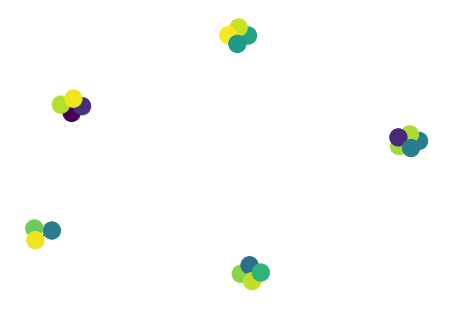

______NOOKS_________
DAY 0


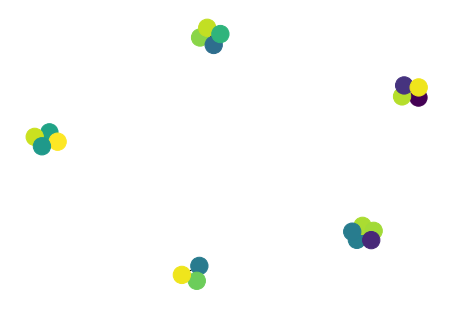

{10: 0, 3: 1, 14: 2, 12: 3, 8: 4, 0: 0, 1: 2, 2: 4, 4: 2, 5: 0, 6: 4, 7: 1, 9: 1, 11: 3, 13: 1, 15: 2, 16: 3, 17: 3, 18: 3, 19: 3} [[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


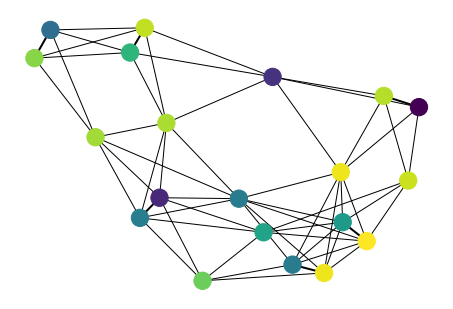

______NOOKS_________
DAY 1


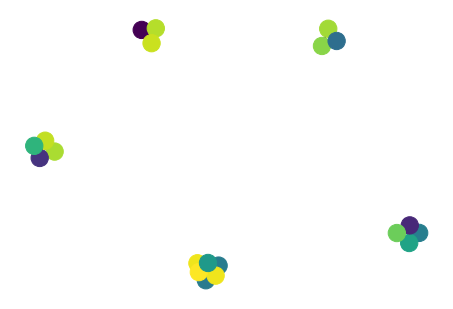

{19: 0, 18: 1, 13: 2, 15: 3, 5: 4, 0: 1, 1: 2, 2: 3, 3: 4, 4: 1, 6: 0, 7: 1, 8: 4, 9: 2, 10: 0, 11: 3, 12: 3, 14: 2, 16: 4, 17: 1} [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
______NETWORK_________


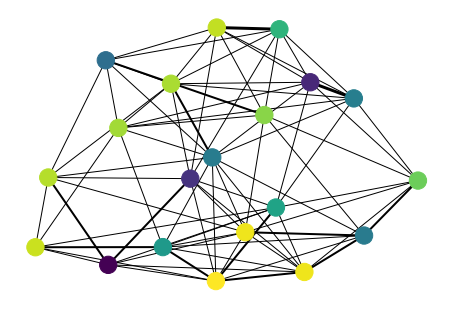

______NOOKS_________
DAY 2


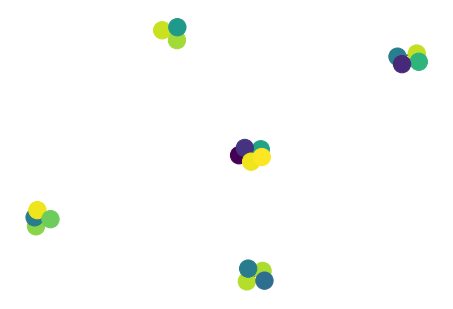

{17: 0, 3: 1, 8: 2, 18: 3, 19: 4, 0: 1, 1: 3, 2: 1, 4: 1, 5: 2, 6: 4, 7: 4, 9: 1, 10: 3, 11: 3, 12: 4, 13: 2, 14: 0, 15: 3, 16: 1} [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]]
______NETWORK_________


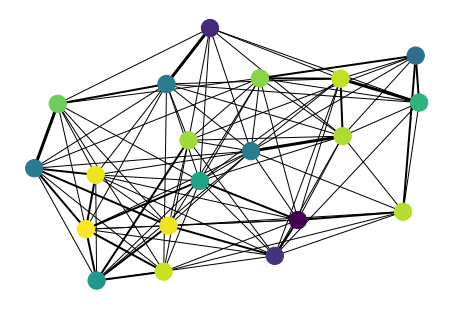

______NOOKS_________
DAY 3


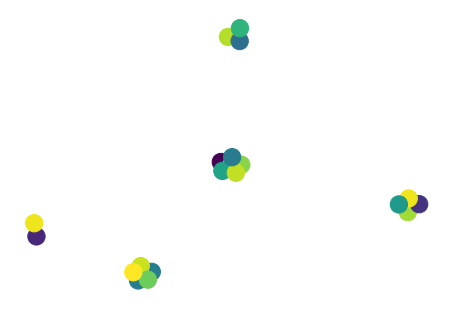

{16: 0, 13: 1, 0: 2, 2: 3, 14: 4, 1: 3, 3: 0, 4: 4, 5: 0, 6: 4, 7: 1, 9: 4, 10: 3, 11: 2, 12: 3, 15: 0, 17: 3, 18: 3, 19: 0} [[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
______NETWORK_________


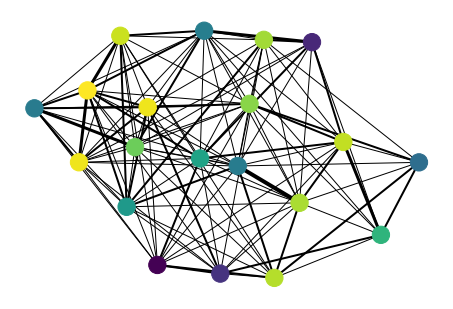

______NOOKS_________
DAY 4


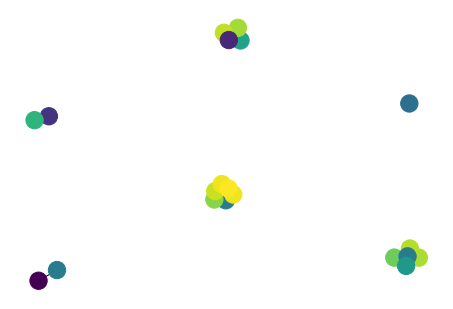

{5: 0, 9: 1, 7: 2, 15: 3, 19: 4, 0: 2, 1: 1, 2: 2, 4: 2, 6: 1, 8: 3, 10: 4, 11: 4, 12: 3, 13: 0, 14: 1, 16: 0, 17: 4, 18: 3} [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1.]]
______NETWORK_________


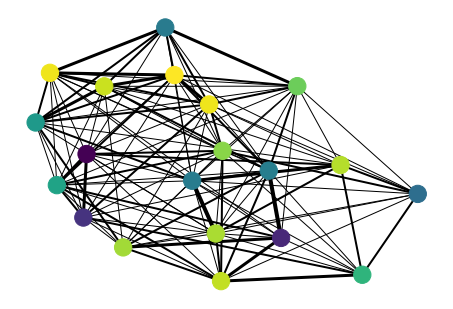

______NOOKS_________
DAY 5


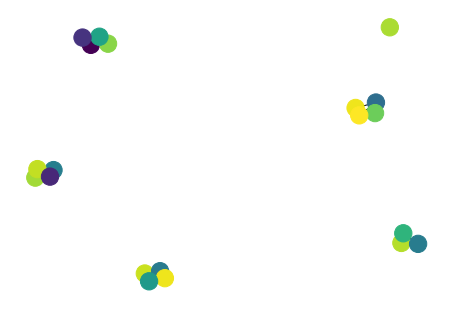

{5: 0, 10: 1, 9: 2, 13: 3, 3: 4, 0: 0, 1: 2, 2: 0, 4: 4, 6: 3, 7: 0, 8: 3, 11: 3, 12: 3, 14: 1, 15: 0, 16: 2, 17: 1, 18: 3, 19: 1} [[1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


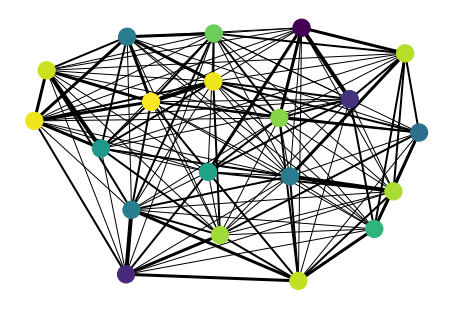

______NOOKS_________
DAY 6


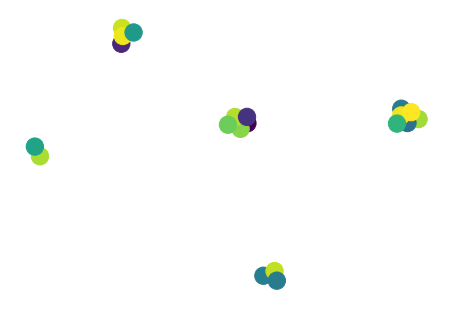

{2: 0, 12: 1, 14: 2, 9: 3, 18: 4, 0: 3, 1: 0, 3: 2, 4: 1, 5: 3, 6: 0, 7: 4, 8: 3, 10: 1, 11: 4, 13: 4, 15: 0, 16: 2, 17: 1, 19: 2} [[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]]
______NETWORK_________


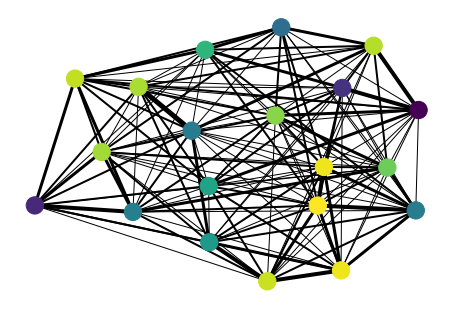

______NOOKS_________
DAY 7


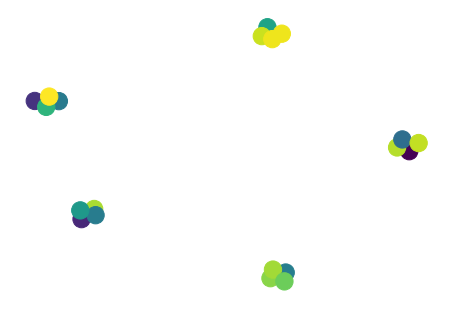

{17: 0, 18: 1, 14: 2, 16: 3, 10: 4, 0: 0, 1: 0, 2: 2, 3: 3, 4: 2, 5: 1, 6: 1, 7: 3, 8: 2, 9: 3, 11: 3, 12: 0, 13: 3, 15: 1, 19: 0} [[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


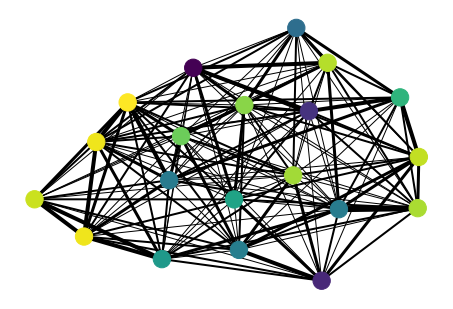

______NOOKS_________
DAY 8


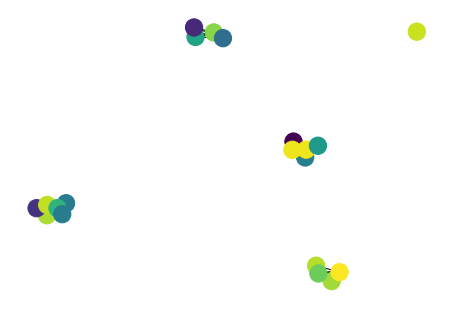

{7: 0, 3: 1, 6: 2, 9: 3, 14: 4, 0: 3, 1: 1, 2: 3, 4: 0, 5: 4, 8: 4, 10: 4, 11: 2, 12: 2, 13: 0, 15: 1, 16: 3, 17: 0, 18: 1, 19: 1} [[0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
______NETWORK_________


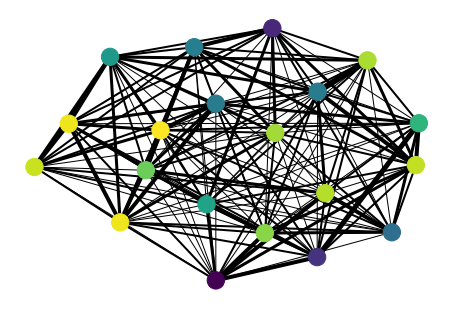

______NOOKS_________
DAY 9


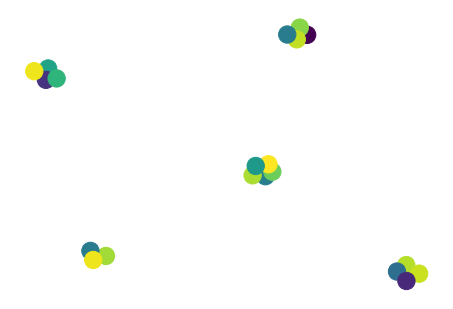

{13: 0, 2: 1, 14: 2, 4: 3, 11: 4, 0: 3, 1: 1, 3: 2, 5: 2, 6: 4, 7: 4, 8: 1, 9: 3, 10: 4, 12: 1, 15: 0, 16: 0, 17: 3, 18: 1, 19: 0} [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


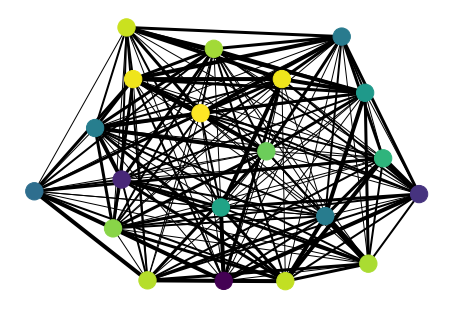

______NOOKS_________
DAY 10


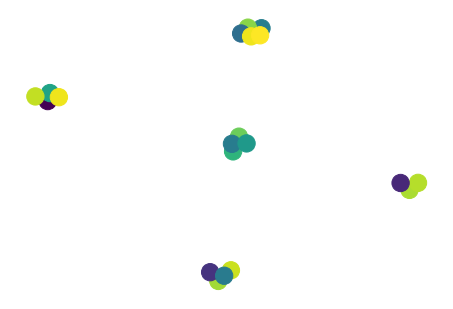

{3: 0, 18: 1, 5: 2, 8: 3, 14: 4, 0: 1, 1: 4, 2: 1, 4: 3, 6: 4, 7: 2, 9: 0, 10: 2, 11: 1, 12: 0, 15: 0, 16: 2, 17: 1, 19: 1} [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
______NETWORK_________


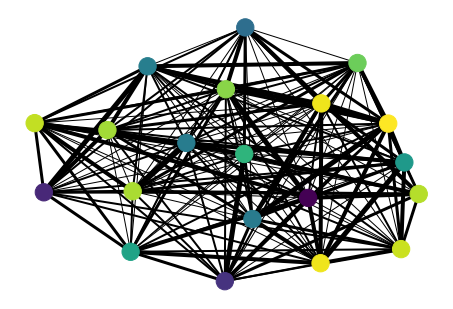

______NOOKS_________
DAY 11


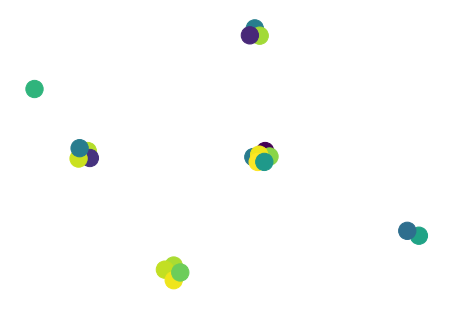

{11: 0, 5: 1, 3: 2, 4: 3, 16: 4, 0: 1, 1: 2, 2: 0, 6: 4, 7: 3, 8: 1, 9: 1, 10: 2, 12: 3, 13: 3, 14: 4, 15: 4, 17: 0, 18: 3, 19: 3} [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]]
______NETWORK_________


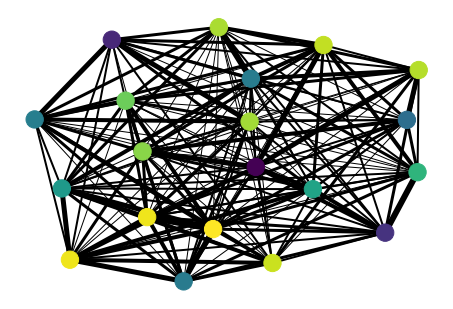

______NOOKS_________
DAY 12


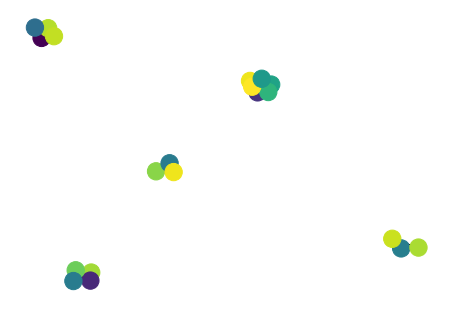

{6: 0, 13: 1, 10: 2, 17: 3, 11: 4, 0: 4, 1: 2, 2: 3, 3: 4, 5: 1, 7: 3, 8: 0, 9: 0, 12: 1, 14: 2, 15: 2, 18: 2, 19: 2} [[0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


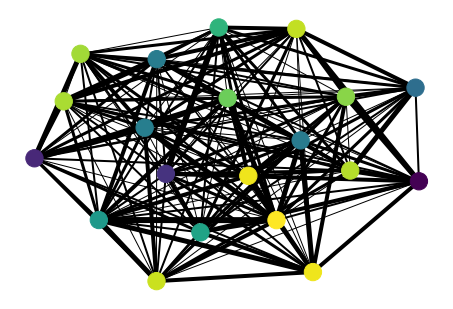

______NOOKS_________
DAY 13


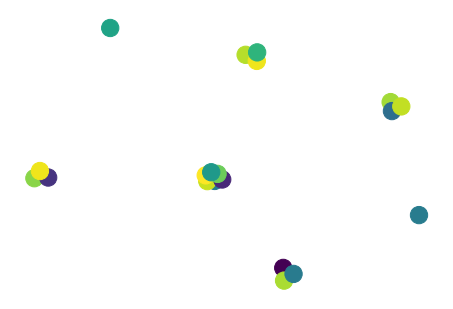

{4: 0, 9: 1, 2: 2, 14: 3, 0: 4, 1: 2, 3: 3, 5: 4, 6: 4, 7: 1, 8: 3, 10: 0, 11: 0, 12: 0, 13: 1, 15: 3, 16: 1, 17: 0, 18: 1, 19: 0} [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


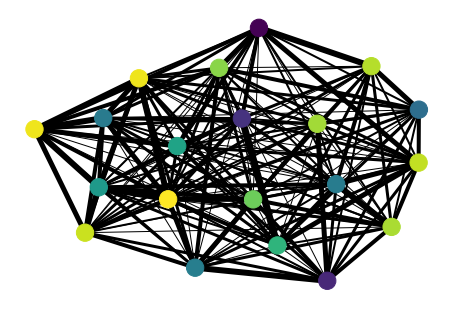

______NOOKS_________
DAY 14


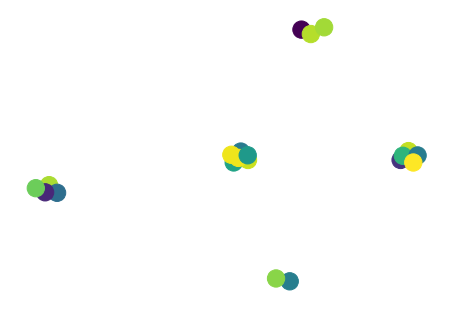

{10: 0, 15: 1, 9: 2, 0: 3, 8: 4, 1: 1, 2: 3, 3: 4, 4: 3, 5: 0, 6: 2, 7: 3, 11: 1, 12: 4, 13: 2, 14: 3, 16: 0, 17: 2, 18: 1, 19: 0} [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


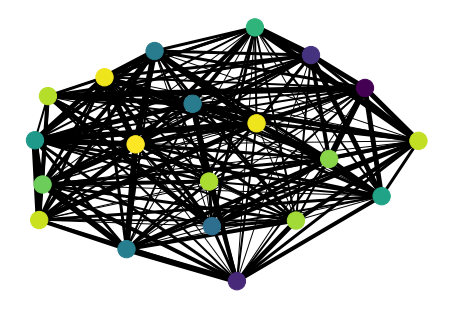

______NOOKS_________
DAY 15


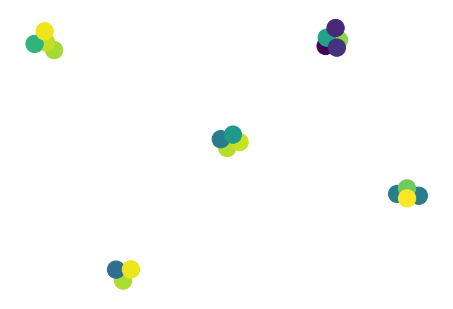

{13: 0, 18: 1, 7: 2, 0: 3, 6: 4, 1: 4, 2: 2, 3: 3, 4: 1, 5: 0, 9: 1, 10: 3, 11: 1, 12: 4, 14: 0, 15: 1, 16: 0, 17: 0, 19: 3} [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


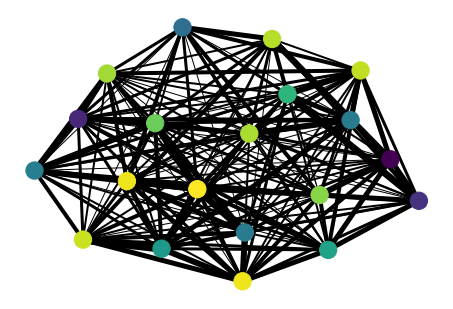

______NOOKS_________
DAY 16


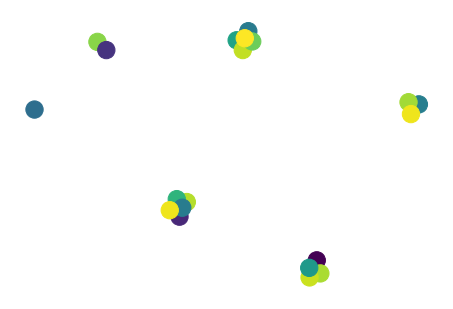

{18: 0, 2: 1, 1: 2, 13: 3, 8: 4, 0: 3, 3: 0, 4: 4, 5: 2, 6: 4, 7: 1, 9: 3, 10: 3, 11: 0, 12: 2, 14: 1, 15: 0, 16: 4, 17: 1, 19: 3} [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
______NETWORK_________


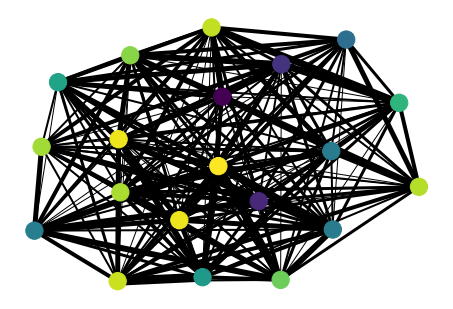

______NOOKS_________
DAY 17


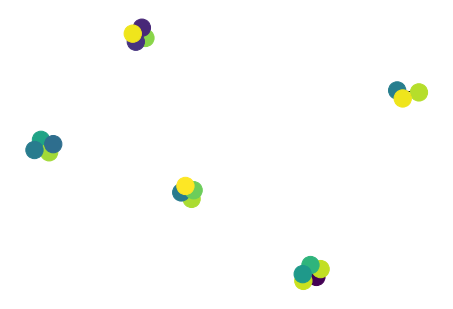

{3: 0, 1: 1, 15: 2, 13: 3, 0: 4, 2: 4, 4: 4, 5: 3, 6: 1, 7: 2, 8: 1, 9: 4, 10: 0, 11: 0, 12: 3, 14: 0, 16: 0, 17: 0, 19: 3} [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


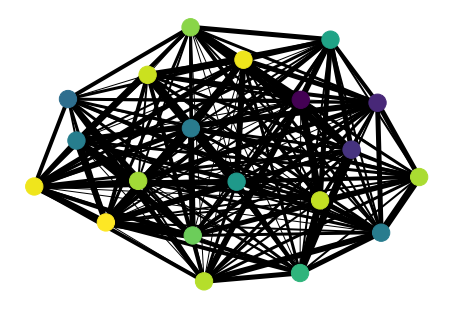

______NOOKS_________
DAY 18


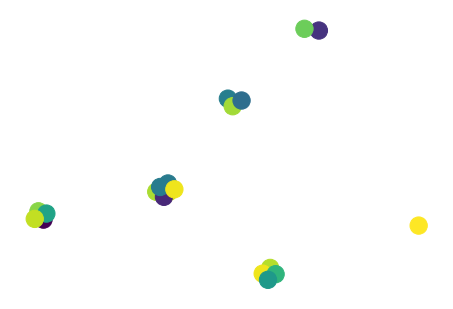

{14: 0, 5: 1, 13: 2, 2: 3, 0: 4, 1: 3, 3: 2, 4: 1, 6: 0, 7: 1, 8: 2, 9: 0, 11: 2, 12: 0, 15: 4, 16: 3, 17: 4, 18: 2, 19: 4} [[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]]
______NETWORK_________


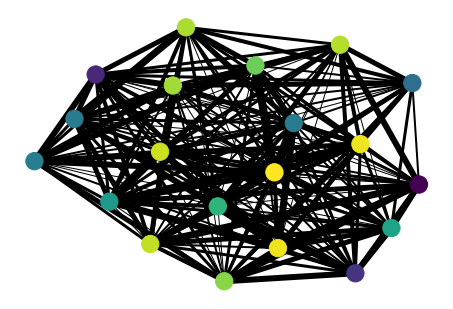

______NOOKS_________
DAY 19


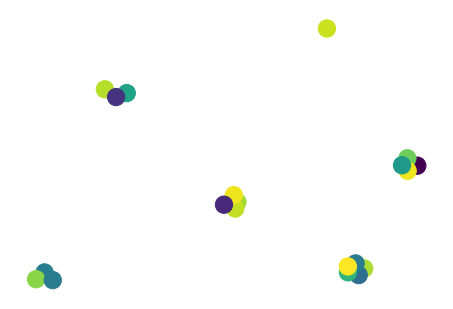

{16: 0, 10: 1, 11: 2, 17: 3, 0: 4, 1: 3, 2: 4, 3: 2, 4: 1, 5: 0, 6: 4, 7: 4, 8: 2, 9: 3, 12: 4, 13: 3, 15: 4, 18: 2, 19: 3} [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]]
______NETWORK_________


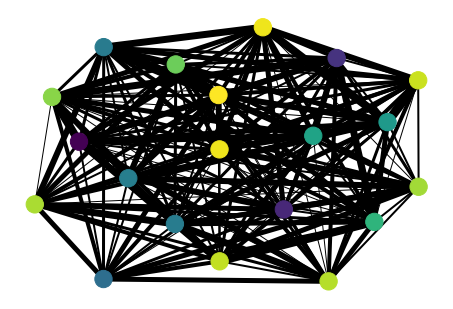

______NOOKS_________
DAY 20


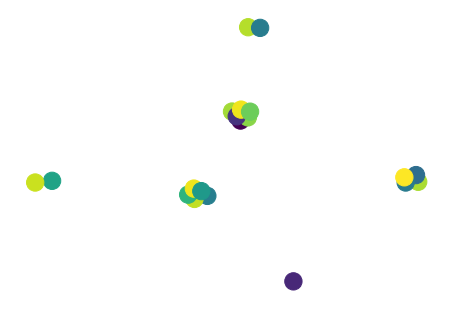

{6: 0, 5: 1, 15: 2, 0: 3, 12: 4, 1: 3, 2: 0, 3: 2, 4: 3, 7: 4, 8: 0, 9: 2, 10: 4, 11: 4, 13: 4, 14: 4, 16: 1, 17: 4, 18: 4, 19: 2} [[0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.]]
______NETWORK_________


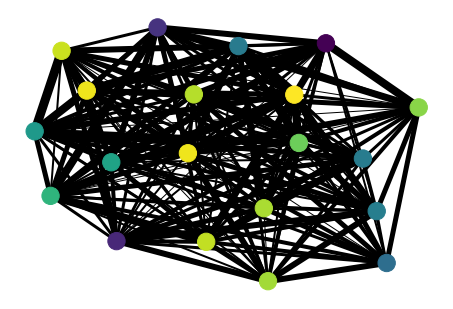

______NOOKS_________
DAY 21


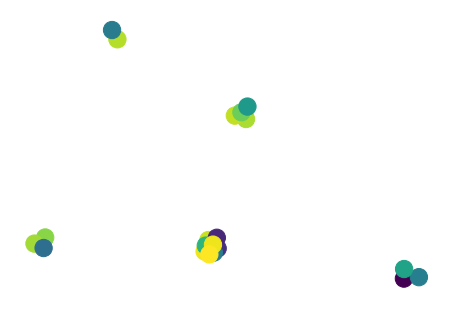

{8: 0, 0: 1, 12: 2, 15: 3, 11: 4, 1: 2, 2: 1, 3: 3, 4: 0, 5: 4, 6: 1, 7: 2, 9: 2, 10: 4, 13: 3, 14: 4, 16: 2, 17: 0, 18: 4, 19: 1} [[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.]]
______NETWORK_________


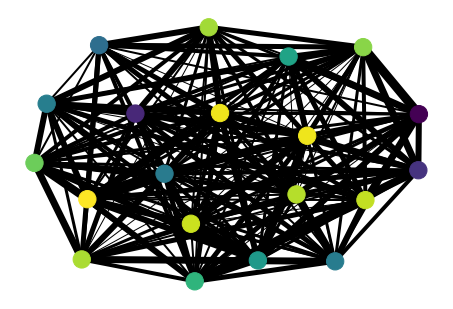

______NOOKS_________
DAY 22


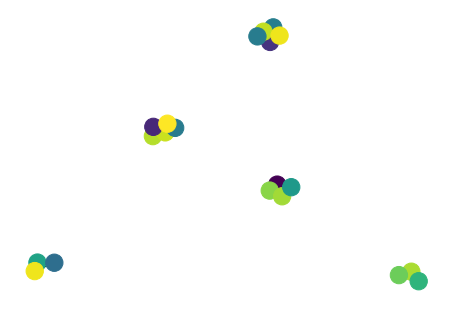

{8: 0, 1: 1, 12: 2, 2: 3, 3: 4, 0: 0, 4: 4, 5: 2, 6: 0, 7: 1, 9: 4, 10: 1, 11: 3, 13: 0, 14: 2, 15: 4, 16: 2, 17: 1, 18: 1, 19: 2} [[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
______NETWORK_________


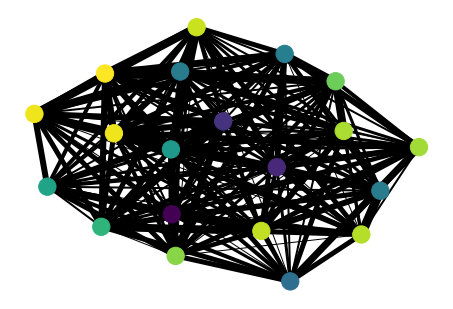

______NOOKS_________
DAY 23


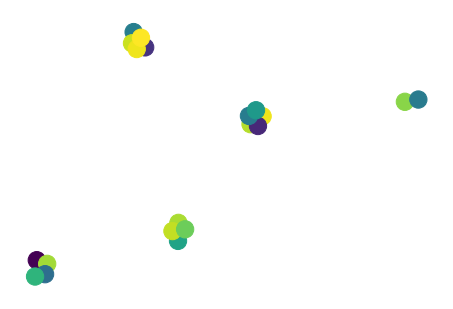

{14: 0, 9: 1, 8: 2, 7: 3, 11: 4, 0: 0, 1: 2, 2: 3, 3: 3, 4: 0, 5: 2, 6: 2, 10: 0, 12: 1, 13: 1, 15: 1, 16: 3, 17: 0, 18: 3, 19: 3} [[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


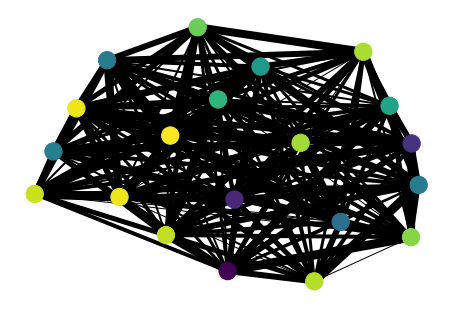

______NOOKS_________
DAY 24


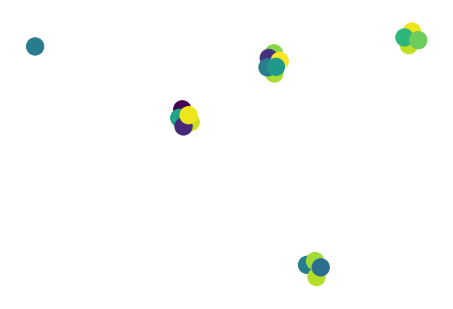

{12: 0, 19: 1, 1: 2, 16: 3, 3: 4, 0: 0, 2: 2, 4: 2, 5: 0, 6: 1, 7: 4, 8: 2, 9: 1, 10: 4, 11: 4, 13: 2, 14: 3, 15: 3, 17: 0, 18: 3} [[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
______NETWORK_________


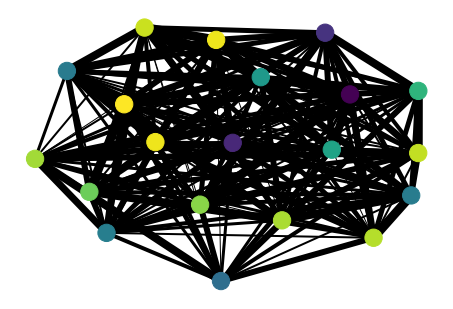

______NOOKS_________
DAY 25


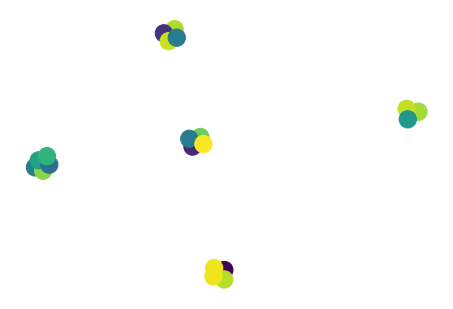

{13: 0, 12: 1, 2: 2, 16: 3, 9: 4, 0: 0, 1: 1, 3: 2, 4: 3, 5: 1, 6: 4, 7: 4, 8: 3, 10: 0, 11: 1, 14: 1, 15: 4, 17: 0, 18: 3, 19: 4} [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]]
______NETWORK_________


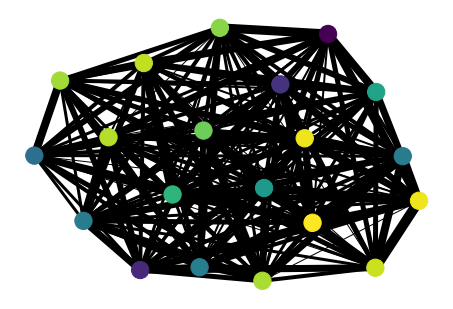

______NOOKS_________
DAY 26


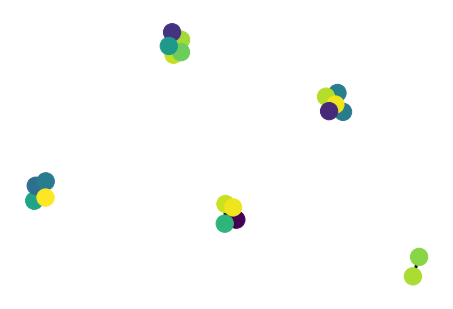

{15: 0, 12: 1, 5: 2, 11: 3, 2: 4, 0: 2, 1: 0, 3: 0, 4: 3, 6: 3, 7: 2, 8: 2, 9: 1, 10: 1, 13: 2, 14: 0, 16: 4, 17: 2, 18: 4, 19: 1} [[0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]]
______NETWORK_________


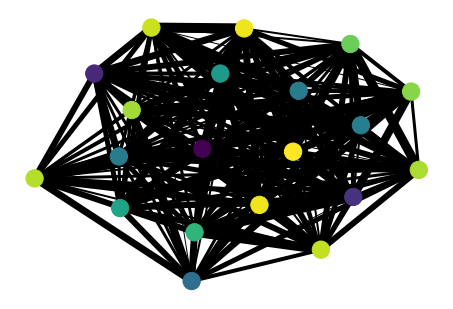

______NOOKS_________
DAY 27


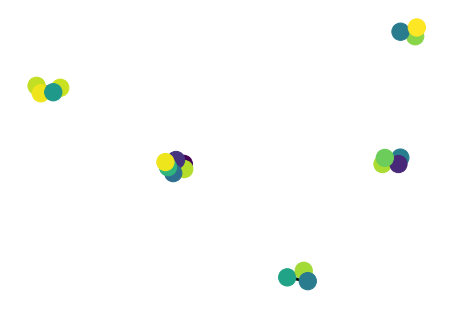

In [12]:
member_vectors = np.random.random(size=(20, 1))
exp = NooksExperiment(member_vectors, alpha=500)
exp.run(num_nooks=5)
